# Movie Genre Trends on IMDB over the years

### Create dataset as per genre ratings and review numbers

The created dataset is called *movie_data_single_genre*, and can be directly downloaded from here https://drive.google.com/file/d/1FeYNXyVxjiIxYYkywCJ_jk6Lt7sefpnX/view?usp=sharing 

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import r2_score

In [61]:
movie_general_data = pd.read_table('../data/general_data.tsv', delimiter='\t', usecols=['tconst','titleType', 'primaryTitle','genres', 'startYear'], dtype={'tconst':str,'titleType': str, 'primaryTitle':str, 'genres':object, 'startYear': object})
movie_rating_data = pd.read_table('../data/rating_data.tsv', delimiter='\t', usecols=['tconst','averageRating','numVotes'], dtype={'tconst':str,'averageRating':float, 'numVotes': int})
movie_data = pd.merge(movie_general_data, movie_rating_data, on='tconst', how='inner')

movie_data.query(expr = "titleType == 'movie'", inplace= True)

movie_data.drop(columns = ['tconst', 'titleType'], inplace= True)
movie_data.reset_index(inplace = True, drop = True)

In [261]:
movie_data.dropna(inplace=True, subset=['startYear', 'averageRating','numVotes'])

null_string = '\\' + 'N'
movie_data.query(expr = 'genres != @null_string & startYear != @null_string', inplace= True)

# turning the year column into int
movie_data['startYear'] = movie_data['startYear'].astype(int) 

if isinstance(movie_data['genres'][0], str) :
    movie_data['genres'] = movie_data['genres'].map(lambda genre: genre.split(','))

movie_data_single_genre = movie_data.explode('genres', ignore_index= True)

movie_data_single_genre.to_csv('../data/movie_data_single_genre.csv') 

display(movie_data_single_genre.head(10))


,primaryTitle,startYear,genres,averageRating,numVotes
0,Miss Jerry,1894,Romance,5.3,204
1,The Corbett-Fitzsimmons Fight,1897,Documentary,5.3,466
2,The Corbett-Fitzsimmons Fight,1897,News,5.3,466
3,The Corbett-Fitzsimmons Fight,1897,Sport,5.3,466
4,The Story of the Kelly Gang,1906,Action,6.0,820
5,The Story of the Kelly Gang,1906,Adventure,6.0,820
6,The Story of the Kelly Gang,1906,Biography,6.0,820
7,The Prodigal Son,1907,Drama,4.4,20
8,Robbery Under Arms,1907,Drama,4.3,24
9,Hamlet,1908,Drama,2.8,26


### Analysis on a specific genre of movie

For example analysis, we start with only one gere, Romance. To obtain relevant data on an yearly basis, a weighted average will be computed for each year. The *averageRating* will be the variables, and the *numVotes* will serve as the weights. This way, we obtain a more realisting indices on the quality of the movie.

In [202]:
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    weighted_rating = (val * wt).sum() / wt.sum()

    return weighted_rating

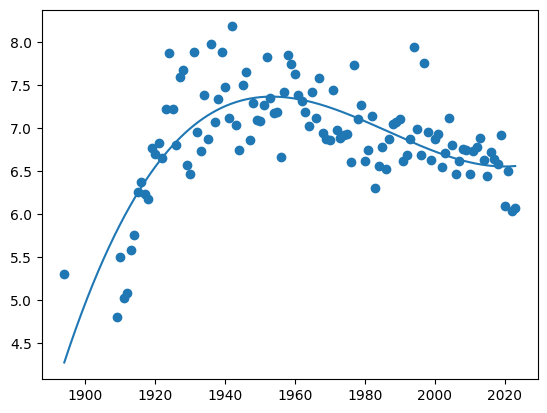

Coef of correlation:0.5340069370481637


In [263]:
romance = movie_data_single_genre.query(expr = "genres == 'Romance'")

rating = romance.groupby('startYear').apply(weighted_average, 'averageRating', 'numVotes')

x = rating.index
y = rating.values

mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))
myline = numpy.linspace(x[0],x[x.size-1], 1000)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()

r = r2_score(y, mymodel(x))

print('Coef of correlation:{}'.format(r))

It can be seen that the coeficinet of correlation is close to 0.5, witch means we can make predicitions, but not very accurate ones. However, a conclusion that can be drawn is that the highest rated romance movies were released between 1940 and 1960. Some of which can be seen below.

In [266]:
display(romance.loc[(romance['startYear'] > 1940) & (romance['startYear']<1960)].nlargest(10, 'averageRating'))

,primaryTitle,startYear,genres,averageRating,numVotes
46352,Meine 99 Bräute,1958,Romance,9.2,20
181206,Humsafar,1953,Romance,9.0,11
40264,Racing Blood,1954,Romance,8.9,17
206279,A Sinful Life,1957,Romance,8.7,9
35064,The Naked and the Wicked,1951,Romance,8.6,33
122924,The Counterfeit Coin,1955,Romance,8.6,2933
155503,Las campanas de Teresa,1957,Romance,8.6,11
165842,Do Sitare,1951,Romance,8.6,11
167368,Anakku Sazali,1956,Romance,8.6,77
174514,Nili,1950,Romance,8.6,12


### Prediction

Making a prediction for a year that does not have any romantic movies in the dataset. However if the year is already whithin the dataset, its corresponding average rating will be displayed. 

In [300]:
year = 1907

if year in set(romance['startYear']):
    prediction = round(rating[year])
    print('The calculated average rating for a romantic movie from {} is {}.'.format(year, prediction)) 
else:
    prediction = round(mymodel(year), 1)
    print('The predicted average rating for a romantic movie from {} is {}.'.format(year, prediction))



The predicted average rating for a romantic movie from 1907 is 5.6.
